In [2]:
# Загружаем датасет рукописных английских букв emnist
# Каждая буква представлена в формате картинки 28х28 пикселей
import kagglehub

path = kagglehub.dataset_download("crawford/emnist")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\fdsaf\.cache\kagglehub\datasets\crawford\emnist\versions\3


In [3]:
# Необходимо взять emnist-letters-test.csv и emnist-letters-train.csv
# Каждая строка в таблице - отдельная картинка
# 785 (28 x 28) столбцов, каждый столбец = величина пикселя 
# Первый столбец — это метка класса (какая это буква). Подробнее в mappings.txt
import pandas as pd # для обработки данных
testing_letter = pd.read_csv(path + '/emnist-letters-test.csv')
training_letter = pd.read_csv(path + '/emnist-letters-train.csv')

print(training_letter.shape) # 88799 = количество элементов для обучения
print(testing_letter.shape) # 14799 = кол-во элементов для тестирования

(88799, 785)
(14799, 785)


(88799,)
(88799, 784)


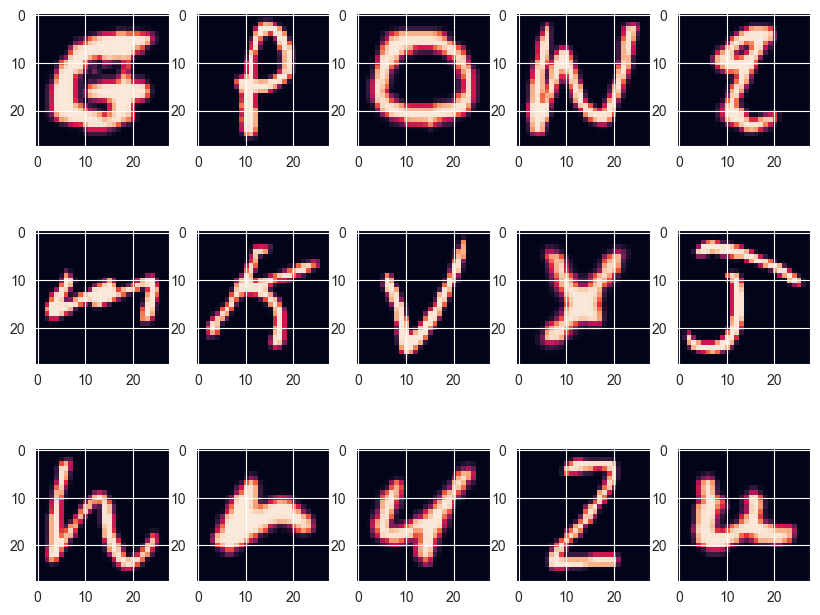

In [4]:
import numpy as np # для линейной алгебры
# training_letter
y1 = np.array(training_letter.iloc[:,0].values) # Берём первый столбец всех строк (метка класса)
x1 = np.array(training_letter.iloc[:,1:].values) # Все строки, все столбцы кроме первого столбца
# testing_letter
y2 = np.array(testing_letter.iloc[:,0].values)
x2 = np.array(testing_letter.iloc[:,1:].values)
print(y1.shape) # метки для обучающей выборки
print(x1.shape) # признаки обучающей выборки


# Проверка картинок
import matplotlib.pyplot as plt # для создания графиков
fig,axes = plt.subplots(3,5,figsize=(10,8)) # создаёт сетку 3х5 из графиков, каждая клетка размером 10х8
for i,ax in enumerate(axes.flat): # индекс, объект оси
    ax.imshow(x1[i].reshape([28,28]).T) # отображает изображение, нужно транспонировать

In [5]:
# Перед тем, как подавать в данные в модель, мы нормализуем и изменим предоставленные нам данные. Это уменьшит сложность моделей и сделает модель эффективно работать, так как для обработки будут менее сложные числа.

# Приводим данные к диапазону [0,1]
train_images = x1 / 255.0
test_images = x2 / 255.0

train_images_number = train_images.shape[0] # кол-во изображений в обучающей выборке
train_images_height = 28
train_images_width = 28
train_images_size = train_images_height*train_images_width

train_images = train_images.reshape(train_images_number, train_images_height, train_images_width, 1)
# кол-во изображений, высота, ширина, 1 = кол-во каналов (1 т.к. чёрно белое)

test_images_number = test_images.shape[0]
test_images_height = 28
test_images_width = 28
test_images_size = test_images_height*test_images_width

test_images = test_images.reshape(test_images_number, test_images_height, test_images_width, 1)

In [6]:
import tensorflow as tf

# Количество классов (26 букв английского алфавита + спец символы)
number_of_classes = 37

# Преобразует метки классов в one-hot encoding.
# Например Если y1[i] = 2, то one-hot encoding будет [0, 0, 1, 0, ..., 0] 
# (длина вектора равна number_of_classes).
y1 = tf.keras.utils.to_categorical(y1, number_of_classes)
y2 = tf.keras.utils.to_categorical(y2, number_of_classes)

In [7]:
train_x_flat = train_images.reshape(train_images.shape[0], -1)
test_x_flat = test_images.reshape(test_images.shape[0], -1)
y1_labels = np.argmax(y1, axis=1)
y2_labels = np.argmax(y2, axis=1)

In [15]:
from minisom import MiniSom
def train_SOM(size=20):
    # 20 * 20 - размерность двумерной карты (400 нейронов)
    # каждый нейрон = вектор длиной 784
    # sigma=1.0 - Радиус влияния: как далеко распространяется обучение по карте. (обновляется нейрон и его соседи)
    # Насколько сильно корректируются веса нейронов при обучении. w = w + learning_rate(x - w)
    som = MiniSom(x=size, y=size, input_len=784, sigma=1.0, learning_rate=0.5)
    # Инициализируем веса случайными числами [0,1]
    som.random_weights_init(train_x_flat)
    # 1. Случайно выбирает одно из входных изображений (вектор из 784 значений).
    # 2. Находит лучший подходящий нейрон (BMU) — тот, у кого веса ближе всего к этому входному образцу. (по евклидовому расстоянию)
    # 3. Обновляет веса этого нейрона (и его соседей в пределах sigma) (Его веса + веса ближайших нейронов немного «подтягиваются» к входу)
    # 3.1 Сближает их с входным вектором.
    # 3.2 Чем ближе сосед, тем сильнее его обновление (затухает с расстоянием).
    # Повторяет это num_iteration раз.
    som.train_random(train_x_flat, num_iteration=10000)
    return som
som = train_SOM()

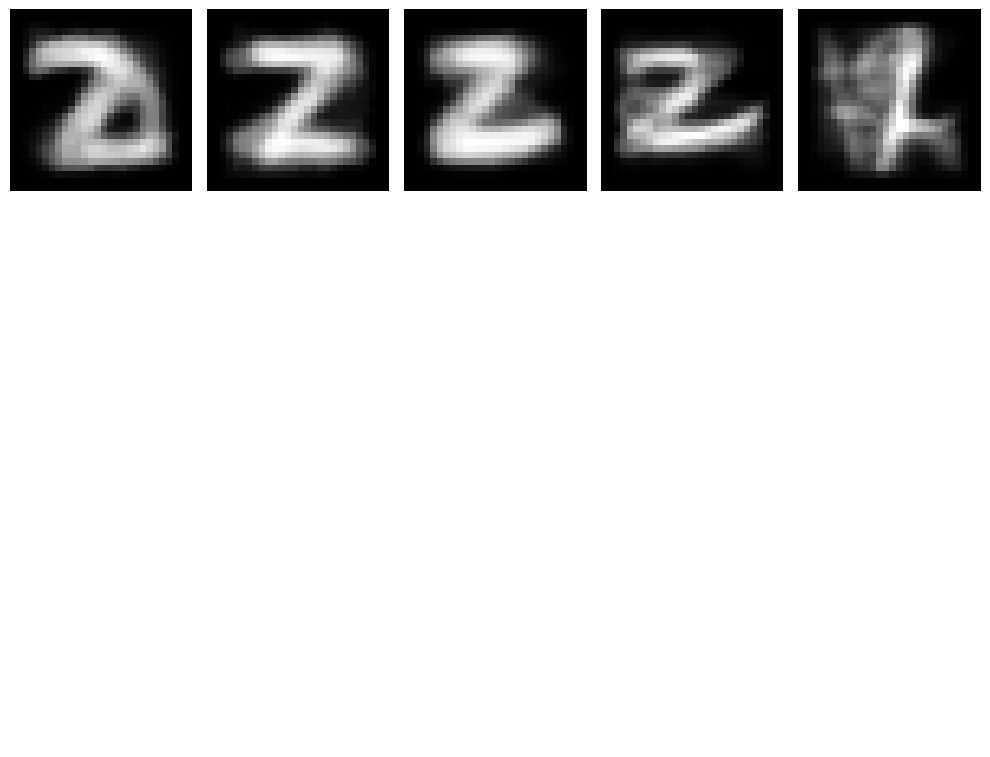

In [16]:
# Количество нейронов, которые будем визуализировать (например, 15 нейронов)
num_neurons = 5

# Извлекаем веса сети Кохонена (форма: (20, 20, 784), где 20x20 - размер сети, 784 - размер входного вектора)
weights = som.get_weights()

# Подготовим график
fig, axes = plt.subplots(3, 5, figsize=(10, 8))

# Отображаем веса нейронов
for i, ax in enumerate(axes.flat):
    if i < num_neurons:
        # Преобразуем веса нейрона в изображение 28x28 и транспонируем для правильной ориентации
        ax.imshow(weights[i // 20, i % 20].reshape(28, 28).T, cmap='gray')
        ax.axis('off')  # Отключаем оси
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
from collections import defaultdict, Counter

def compare_neurons(s_o_m=som):
    # сопоставление: координата нейрона -> список меток, которые к нему попали
    # если к несущ. ключу предоставим доступ, создадим для него пустой список в значениях
    labels_map = defaultdict(list)
    
    #  определяется, какой нейрон в сети Кохонена является победителем для этого примера.
    for i, x in enumerate(train_x_flat):
        winner = s_o_m.winner(x) # возвращает координаты нейрона
        labels_map[winner].append(y1_labels[i]) # добавляем к нейрону его метку
    
    # каждому нейрону присвоим наиболее частую метку
    neuron_labels = {pos: Counter(labels).most_common(1)[0][0] for pos, labels in labels_map.items()}
    return neuron_labels
neuron_labels = compare_neurons()


In [23]:
def predict_som(x, s_o_m=som, neuron_labelz=neuron_labels):
    winner = s_o_m.winner(x)
    return neuron_labelz.get(winner, -1)  # -1 если нейрон не обучен

def get_accuracy(s_o_m=som, neuron_labelz=neuron_labels):
    predicted = np.array([predict_som(x, s_o_m, neuron_labelz) for x in test_x_flat])
    true = y2_labels
    accuracy = np.mean(predicted == true)
    print(f"SOM accuracy: {accuracy * 100:.2f}%")
    return accuracy
get_accuracy()


SOM accuracy: 53.32%


0.5332117034934792

Обучение SOM с размером карты 14x14...
SOM accuracy: 53.71%
Точность: 53.71%
Обучение SOM с размером карты 16x16...
SOM accuracy: 56.40%
Точность: 56.40%
Обучение SOM с размером карты 18x18...
SOM accuracy: 57.33%
Точность: 57.33%
Обучение SOM с размером карты 20x20...
SOM accuracy: 58.62%
Точность: 58.62%
Обучение SOM с размером карты 22x22...
SOM accuracy: 60.94%
Точность: 60.94%
Обучение SOM с размером карты 24x24...
SOM accuracy: 62.11%
Точность: 62.11%
Обучение SOM с размером карты 26x26...
SOM accuracy: 62.63%
Точность: 62.63%
Обучение SOM с размером карты 28x28...
SOM accuracy: 63.52%
Точность: 63.52%
Обучение SOM с размером карты 30x30...
SOM accuracy: 64.02%
Точность: 64.02%
Обучение SOM с размером карты 32x32...
SOM accuracy: 64.67%
Точность: 64.67%
Обучение SOM с размером карты 34x34...
SOM accuracy: 64.58%
Точность: 64.58%
Обучение SOM с размером карты 36x36...
SOM accuracy: 66.02%
Точность: 66.02%


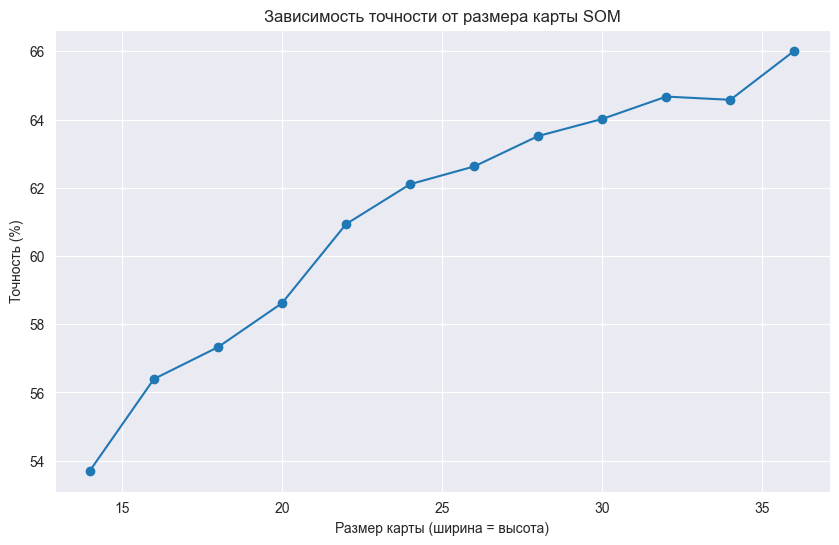

In [24]:
# Исследуем размеры от 14 до 36 с шагом 2
map_sizes = list(range(14, 38, 2))
accuracies = []
for size in map_sizes:
    print(f"Обучение SOM с размером карты {size}x{size}...")
    som = train_SOM(size)
    neuron_labels = compare_neurons(som)
    acc = get_accuracy(som, neuron_labels)
    print(f"Точность: {acc * 100:.2f}%")
    accuracies.append(acc)

# Построим график
plt.figure(figsize=(10, 6))
plt.plot(map_sizes, [a * 100 for a in accuracies], marker='o')
plt.title('Зависимость точности от размера карты SOM')
plt.xlabel('Размер карты (ширина = высота)')
plt.ylabel('Точность (%)')
plt.grid(True)
plt.show()